In [1]:
#@title Setup Repository
import os
#os.chdir('/content')
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
CODE_DIR = 'encoder4editing'

#!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
#!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
#!unzip ninja-linux.zip -d /usr/local/bin/
#!update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

#%load_ext autoreload
#%autoreload 2

## Step 1: Select Experiment Type
Select which experiment you wish to perform inference on:
1. ffhq_encode
2. cars_encode
3. horse_encode
4. church_encode

In [2]:
experiment_type = 'bedroom_encode' #@param ['ffhq_encode', 'cars_encode', 'horse_encode', 'church_encode']

## Step 2: Download Pretrained Models 
As part of this repository, we provide pretrained models for each of the above experiments. We'll download the model for the selected experiments and save it to the folder `pretrained_models`.

In [ ]:
#@title Download
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.  
While we provide default values to run this script, feel free to change as needed.

In [3]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg"
    },
    "cars_encode": {
        "model_path": "pretrained_models/e4e_cars_encode.pt",
        "image_path": "notebooks/images/car_img.jpg"
    },
    "horse_encode": {
        "model_path": "pretrained_models/e4e_horse_encode.pt",
        "image_path": "notebooks/images/horse_img.jpg"
    },
    "church_encode": {
        "model_path": "pretrained_models/e4e_church_encode.pt",
        "image_path": "notebooks/images/church_img.jpg"
    }, 
    "bedroom_encode": {
        "model_path": "pretrained_models/bedroom_encode.pt",
        "image_path": "notebooks/images/church_img.jpg"
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [5]:
#model_path = EXPERIMENT_ARGS['model_path']
#model_path = 'pretrained_models/bedroom_encode.pt'
print(os.getcwd())
model_path = '../../new/experiment2/directory/checkpoints/iteration_270000.pt'
#model_path = '../new/experiment2/directory/checkpoints/iteration_200000.pt'
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

/data/vision/torralba/scratch/audcui/encoder4editing/notebooks/encoder4editing
Loading e4e over the pSp framework from checkpoint: ../../new/experiment2/directory/checkpoints/iteration_270000.pt
Model successfully loaded!


## Step 5: Visualize Input

In [11]:
#image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
#print(image_path)

image_path = '../notebooks/images/brown_bedroom.png'
print(os.listdir('notebooks/images/'))
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

['input_img.jpg', 'horse_img.jpg', 'car_img.jpg', 'church_img.jpg']


### Image Alignment
For the FFHQ StyleGAN inversion, we first align the image

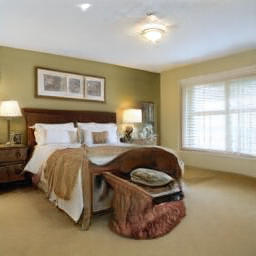

In [12]:
'''if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
'''
def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

## Step 6: Perform Inference

In [13]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

In [14]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

torch.Size([16, 512])
Inference took 1.7194 seconds.


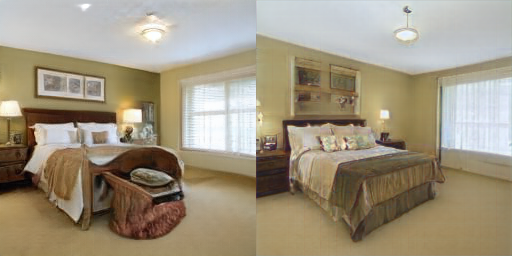

In [15]:
with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print(latent.shape)
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

In [20]:
print(latent)
torch.save(latent, '../../../saved_latents/bedroom_w_plus.pt')

tensor([[ 5.9145,  0.3262,  0.0145,  ...,  0.3615,  0.1958, -0.2497],
        [ 2.9882,  0.6811, -0.4046,  ...,  1.1250,  0.9242, -1.0301],
        [ 6.0890,  0.4073, -1.0349,  ..., -1.2802,  0.0990, -1.5641],
        ...,
        [ 6.1649,  0.5680,  0.1162,  ...,  0.8142,  0.6176,  0.3628],
        [ 6.0242,  0.7583,  0.3022,  ...,  0.4965,  0.4060, -0.5097],
        [ 6.7540, -0.0321, -0.1074,  ...,  0.2342,  0.0546,  0.1187]],
       device='cuda:0')


## Edit

In [ ]:
from editings import latent_editor
is_cars = experiment_type == 'cars_encode'
editor = latent_editor.LatentEditor(net.decoder, is_cars)

In [ ]:
# InterFaceGAN
interfacegan_directions = {
    'ffhq_encode': {
        'age': 'editings/interfacegan_directions/age.pt',
        'smile': 'editings/interfacegan_directions/smile.pt',
        'pose': 'editings/interfacegan_directions/pose.pt'
    }
}
available_interfacegan_directions = None
if experiment_type in interfacegan_directions:  # List supported directions for the current experiment
    available_interfacegan_directions = interfacegan_directions[experiment_type]
    print(list(available_interfacegan_directions.keys()))

In [ ]:
# As an example, we currently released the age and smile directions for the FFHQ StyleGAN Generator.
interfacegan_direction = torch.load(available_interfacegan_directions["age"]).cuda()

# For a single edit:
result = editor.apply_interfacegan(latents, interfacegan_direction, factor=-3).resize(resize_dims)
display_alongside_source_image(result, input_image)

In [ ]:
# Or, apply a range of editings
editor.apply_interfacegan(latents, interfacegan_direction, factor_range=(-5, 5))

In [ ]:
# GANSpace
# Here we provide the editings for the cars domain as displayed in the paper, as well as several examples for the facial domain,
# taken from the official GANSpace repository.
if experiment_type == 'ffhq_encode':
    ganspace_pca = torch.load('editings/ganspace_pca/ffhq_pca.pt')
    directions = {
        'eye_openness':            (54,  7,  8,  20),
        'smile':                   (46,  4,  5, -20),
        'trimmed_beard':           (58,  7,  9,  20),
        'white_hair':              (57,  7, 10, -24),
        'lipstick':                (34, 10, 11,  20)
    }
elif experiment_type == 'cars_encode':
    ganspace_pca = torch.load('editings/ganspace_pca/cars_pca.pt')
    directions = {
        "Viewpoint I": (0, 0, 5, 2),
        "Viewpoint II": (0, 0, 5, -2),
        "Cube": (16, 3, 6, 25),
        "Color": (22, 9, 11, -8),
        "Grass": (41, 9, 11, -18),
    }
print(f'Available Editings: {list(directions.keys())}')
editor.apply_ganspace(latents, ganspace_pca, [directions["white_hair"], directions["eye_openness"], directions["smile"]])

In [ ]:
# SeFa
# Note that each model behaves differently to the selected editing parameters.
# We encourage the user to try out different configurations, using different indices, start/end_distance, etc.
# In the paper, we used start and end distance of -15.0, +15.0 over the horses and churches domains.
# See code at editings/sefa.py for further options.
editor.apply_sefa(latents, indices=[2, 3, 4, 5], start_distance=0., end_distance=15.0, step=3)

In [ ]:
# Note, that for Styleflow editings, 
# one need to save the output latent codes and load them over the official StyleFlow repository:
# torch.save(latents, 'latents.pt')